In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import pandas as pd
import numpy as np
matplotlib.style.use('ggplot')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.model_selection import KFold
import copy

c:\Users\mdzak\anaconda3\envs\fyp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
selected_dim = 128

### Import relevant CSV files

In [3]:
dimension = pd.read_csv('../results/results' + str(selected_dim) + 'D_latent_space_gene_exp.tsv',sep='\t')
cell_line_name = pd.read_csv('../results_clean/cell_line_name.csv')
gdsc_drug = pd.read_csv('../results_clean/gdsc_drug_nodash.csv')
dimension.drop(columns=['Unnamed: 0'], inplace=True)
gdsc_drug.drop(columns=['Unnamed: 0'], inplace= True)
dimension['CELL_LINE_NAME'] = cell_line_name['CELL_LINE_NAME']

### Merge with drugs and one hot encode drug name

In [4]:
dimension_w_drug = pd.merge(dimension, gdsc_drug, on='CELL_LINE_NAME')
dimension_w_drug.drop(columns=['CELL_LINE_NAME'],inplace=True)
dimension_w_drug = pd.get_dummies(dimension_w_drug, columns=['DRUG_NAME'])

### Scaling

In [5]:
scaler = MinMaxScaler()
col = dimension_w_drug.drop(columns=['LN_IC50']).columns
X = scaler.fit_transform(dimension_w_drug.drop(columns=['LN_IC50']))
X = pd.DataFrame(X, columns=col)
y = dimension_w_drug['LN_IC50']

In [6]:
# scaler = MinMaxScaler()
# col = dimension_w_drug.drop(columns=['LN_IC50']).columns
# X = dimension_w_drug.drop(columns=['LN_IC50'])
# y = dimension_w_drug['LN_IC50']

In [7]:
X

,0,1,2,3,4,5,6,7,8,9,...,DRUG_NAME_WZ4003,DRUG_NAME_Wee1 Inhibitor,DRUG_NAME_Wnt-C59,DRUG_NAME_XAV939,DRUG_NAME_YK-4-279,DRUG_NAME_ZM447439,DRUG_NAME_Zoledronate,DRUG_NAME_alpha-lipoic acid,DRUG_NAME_ascorbate (vitamin C),DRUG_NAME_glutathione
0,0.098109,0.973217,0.934634,0.082488,0.003494,0.057198,0.040924,0.983428,0.953679,0.993825,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.098109,0.973217,0.934634,0.082488,0.003494,0.057198,0.040924,0.983428,0.953679,0.993825,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.098109,0.973217,0.934634,0.082488,0.003494,0.057198,0.040924,0.983428,0.953679,0.993825,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.098109,0.973217,0.934634,0.082488,0.003494,0.057198,0.040924,0.983428,0.953679,0.993825,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.098109,0.973217,0.934634,0.082488,0.003494,0.057198,0.040924,0.983428,0.953679,0.993825,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157613,0.096684,0.982266,0.919321,0.076251,0.038997,0.069472,0.093618,0.937792,0.913322,0.953113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
157614,0.096684,0.982266,0.919321,0.076251,0.038997,0.069472,0.093618,0.937792,0.913322,0.953113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
157615,0.096684,0.982266,0.919321,0.076251,0.038997,0.069472,0.093618,0.937792,0.913322,0.953113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
157616,0.096684,0.982266,0.919321,0.076251,0.038997,0.069472,0.093618,0.937792,0.913322,0.953113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [8]:
y

0         -2.902460
1         -4.384381
2          3.372862
3          4.189364
4         -3.693711
            ...    
157613     6.556376
157614    12.036685
157615    11.217061
157616     8.823341
157617     9.995125
Name: LN_IC50, Length: 157618, dtype: float64

## PREDICTOR (K Fold Cross Validation)

In [9]:
# import xgboost as xgb
# model = xgb.XGBRegressor()
# cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
# scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# scores = abs(scores)
# print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()))

## PREDICTOR (Pytorch)

In [10]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self,df):
 
        col = df.drop(columns=['LN_IC50']).columns
        x = scaler.fit_transform(df.drop(columns=['LN_IC50']))
        x = pd.DataFrame(X, columns=col)
        y = df['LN_IC50']
        x = np.array(x)
        y = np.array(y)
    
        self.x_train=torch.tensor(x,dtype=torch.float32)
        self.y_train=torch.tensor(y,dtype=torch.float32)
 
    def __len__(self):
        return len(self.y_train)
   
    def __getitem__(self,idx):
        return self.x_train[idx],self.y_train[idx]

In [11]:
dataset = MyDataset(dimension_w_drug)

In [12]:
import torch.nn as nn

import torch.nn as nn
 
class predictor_model(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
    nn.Linear(414, 200),
    nn.ReLU(),
    nn.Linear(200, 1)
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)


In [13]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

In [14]:
k_folds = 5
n_epochs = 20
loss_function = nn.MSELoss()

results = {}
torch.manual_seed(3)

kfold = KFold(n_splits=k_folds, shuffle = True)
batch = 128
best_mse = np.inf
best_weights = None
history = []
device = torch.device('cuda')

In [43]:
# Start print
print('--------------------------------')
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=batch, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=batch, sampler=test_subsampler)
    
    # Init the neural network
    model = predictor_model()
    model = model.to(device)
    model.apply(reset_weights)
    best_mse = np.inf

    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr= 0.02)

    # start training
    for epoch in range(0, n_epochs):
        print(f'Starting epoch {epoch+1}')
        model.train()
        # Set current loss value
        current_loss = 0.0
        # Iterate over the DataLoader for training data
        for i, data in enumerate(trainloader, 0):
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Print statistics
            current_loss = loss.item()
            if i % 500 == 499:
                print('Loss after mini-batch: ' + str(current_loss))
            current_loss = 0


        # Process is complete.
    print('Training process has finished. Saving trained model.')
    # Saving the model
    # save_path = f'./model-fold-{fold}.pth'
    # torch.save(model.state_dict(), save_path)

    # Print about testing
    print('Starting testing')


    # Evaluation for this fold
    with torch.no_grad():

      # Iterate over the test data and generate predictions
        for i, data in enumerate(testloader, 0):
        # Get inputs
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)

            val_loss = loss_function(outputs, targets)
            val_loss = float(val_loss)
            history.append(val_loss)
            if val_loss < best_mse:
                best_mse = val_loss
                best_weights = copy.deepcopy(model.state_dict())
        print('Best MSE for fold ' + str(fold) + ' is: ' + str(best_mse))
        results[fold] = best_mse

# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results.items():
    print(f'Fold {key}: {value} %')
    sum += value
print(f'Average: {sum/len(results.items())}')




--------------------------------
FOLD 0
--------------------------------
Reset trainable parameters of layer = Linear(in_features=414, out_features=200, bias=True)
Reset trainable parameters of layer = Linear(in_features=200, out_features=1, bias=True)
Starting epoch 1


c:\Users\mdzak\anaconda3\envs\fyp\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after mini-batch: 8.048633575439453


c:\Users\mdzak\anaconda3\envs\fyp\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Starting epoch 2
Loss after mini-batch: 5.92170524597168
Starting epoch 3
Loss after mini-batch: 7.3650994300842285
Starting epoch 4
Loss after mini-batch: 9.361347198486328
Starting epoch 5
Loss after mini-batch: 8.78515338897705
Starting epoch 6
Loss after mini-batch: 5.473708629608154
Starting epoch 7
Loss after mini-batch: 6.977084159851074
Starting epoch 8
Loss after mini-batch: 5.985025405883789
Starting epoch 9
Loss after mini-batch: 9.056744575500488
Starting epoch 10
Loss after mini-batch: 6.7856950759887695


: 

: 

### No CV

In [15]:
dim_np = np.array(dimension_w_drug)
dim_col = dimension_w_drug.columns
train, test = train_test_split(dim_np, train_size=0.8, shuffle=True, random_state=0)
train = pd.DataFrame(train, columns=dim_col)
test = pd.DataFrame(test, columns=dim_col)


In [16]:
train_dataset = MyDataset(train)
test_dataset = MyDataset(test)
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=False)
test_loader = DataLoader(test_dataset,batch_size=batch, shuffle=False)

In [17]:
model = predictor_model()
model = model.to(device)
best_mse = np.inf

# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr= 0.02)

# start training
for epoch in range(0, n_epochs):
    print(f'Starting epoch {epoch+1}')
    model.train()
    # Set current loss value
    current_loss = 0.0
    # Iterate over the DataLoader for training data
    for i, data in enumerate(train_loader, 0):
        x, y = data
        x, y = x.float(), y.float()
        y = y.reshape((y.shape[0],1))
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_function(y_pred, y)
        
        loss.backward()
        optimizer.step()
        # Print statistics
        current_loss += loss.item()
        if i % 128 == 0:
            print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
            current_loss = 0.0

Starting epoch 1
Loss after mini-batch     1: 0.028
Loss after mini-batch   129: 1.958
Loss after mini-batch   257: 1.982
Loss after mini-batch   385: 2.011
Loss after mini-batch   513: 1.995
Loss after mini-batch   641: 1.933
Loss after mini-batch   769: 1.957
Loss after mini-batch   897: 1.996
Starting epoch 2
Loss after mini-batch     1: 0.013
Loss after mini-batch   129: 1.891
Loss after mini-batch   257: 1.966
Loss after mini-batch   385: 1.974
Loss after mini-batch   513: 1.996
Loss after mini-batch   641: 1.939
Loss after mini-batch   769: 1.954
Loss after mini-batch   897: 1.989
Starting epoch 3
Loss after mini-batch     1: 0.013
Loss after mini-batch   129: 1.885
Loss after mini-batch   257: 1.960
Loss after mini-batch   385: 1.965
Loss after mini-batch   513: 1.991
Loss after mini-batch   641: 1.930
Loss after mini-batch   769: 1.951
Loss after mini-batch   897: 1.984
Starting epoch 4
Loss after mini-batch     1: 0.013
Loss after mini-batch   129: 1.877
Loss after mini-batch 

MSE: 2.78
RMSE: 1.67


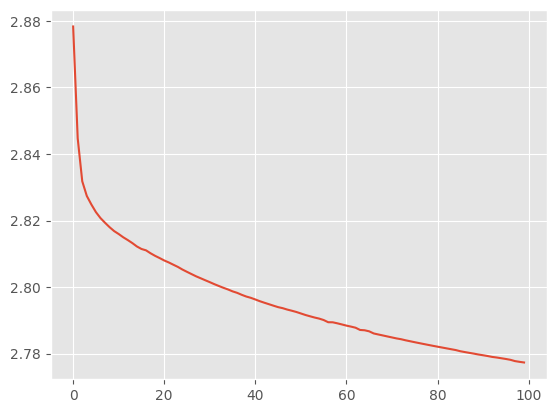

In [17]:
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()